In [1]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import os

%matplotlib inline
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.inception_v3 import InceptionV3
from keras import backend as K 
import random
import urllib.request
import matplotlib.image as mpimg

from skimage.filters import rank, threshold_otsu
from skimage import io
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.morphology import closing, square, disk

# Loading Data

In [2]:
# Defining the path for train and test images
data_dir = pathlib.Path("../input/plantvillage-dataset/color")
train='../input/plantvillage-dataset/color'

In [3]:
# Here we have two class.
dataset_path_train = os.listdir(data_dir)
print (dataset_path_train)
print("Types of classes labels found: ", len(dataset_path_train))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

In [4]:
image_count_train = len(list(data_dir.glob('*/*.JPG')))
print("The number of Train data:",image_count_train)

The number of Train data: 52803


In [5]:
# This Parameter we can use it in the network and model
batch_size = 32
img_height = 224
img_width = 224

In [6]:
# For train data set
train_ds = image_dataset_from_directory(data_dir, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 54305 files belonging to 38 classes.
Using 43444 files for training.


In [7]:
# here we can put the validate data
val_ds = image_dataset_from_directory(data_dir, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [8]:
# here we can put the validate data
test = image_dataset_from_directory(data_dir, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=None)

Found 54305 files belonging to 38 classes.


In [ ]:
# Here We give the name of the data the we found the Benign dataset and malignant
class_names = train_ds.class_names
print(len(class_names))
print( class_names)


In [10]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 224, 224, 3)
(32,)


# Creat Model


In [11]:
num_classes = 38

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [12]:
# Compile the model 

## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0

In [15]:
epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1188/1358 [=========================>....] - ETA: 27s - loss: 1.0438 - accuracy: 0.7043

Cleanup called...


1358/1358 [==============================] - 299s 213ms/step - loss: 0.9803 - accuracy: 0.7207 - val_loss: 0.5431 - val_accuracy: 0.8328
Epoch 2/10
1190/1358 [=========================>....] - ETA: 9s - loss: 0.3469 - accuracy: 0.8900

Cleanup called...


1358/1358 [==============================] - 98s 72ms/step - loss: 0.3420 - accuracy: 0.8917 - val_loss: 0.4032 - val_accuracy: 0.8790
Epoch 3/10
1189/1358 [=========================>....] - ETA: 9s - loss: 0.1889 - accuracy: 0.9378

Cleanup called...


1358/1358 [==============================] - 97s 71ms/step - loss: 0.1863 - accuracy: 0.9385 - val_loss: 0.4288 - val_accuracy: 0.8826
Epoch 4/10
1190/1358 [=========================>....] - ETA: 9s - loss: 0.1302 - accuracy: 0.9566

Cleanup called...


1358/1358 [==============================] - 92s 67ms/step - loss: 0.1273 - accuracy: 0.9574 - val_loss: 0.4050 - val_accuracy: 0.8964
Epoch 5/10
1191/1358 [=========================>....] - ETA: 8s - loss: 0.0925 - accuracy: 0.9694

Cleanup called...


1358/1358 [==============================] - 88s 65ms/step - loss: 0.0914 - accuracy: 0.9697 - val_loss: 0.3415 - val_accuracy: 0.9166
Epoch 6/10
1190/1358 [=========================>....] - ETA: 9s - loss: 0.0770 - accuracy: 0.9750

Cleanup called...


1358/1358 [==============================] - 91s 66ms/step - loss: 0.0749 - accuracy: 0.9756 - val_loss: 0.4216 - val_accuracy: 0.8992
Epoch 7/10
1190/1358 [=========================>....] - ETA: 9s - loss: 0.0629 - accuracy: 0.9790

Cleanup called...


1358/1358 [==============================] - 91s 67ms/step - loss: 0.0627 - accuracy: 0.9794 - val_loss: 0.3594 - val_accuracy: 0.9159
Epoch 8/10
1190/1358 [=========================>....] - ETA: 9s - loss: 0.0620 - accuracy: 0.9792

Cleanup called...


1358/1358 [==============================] - 91s 67ms/step - loss: 0.0643 - accuracy: 0.9786 - val_loss: 0.4127 - val_accuracy: 0.9111
Epoch 9/10
1190/1358 [=========================>....] - ETA: 8s - loss: 0.0489 - accuracy: 0.9845

Cleanup called...


1358/1358 [==============================] - 89s 65ms/step - loss: 0.0478 - accuracy: 0.9847 - val_loss: 0.4923 - val_accuracy: 0.8970
Epoch 10/10
1190/1358 [=========================>....] - ETA: 9s - loss: 0.0503 - accuracy: 0.9841

Cleanup called...


1358/1358 [==============================] - 93s 68ms/step - loss: 0.0510 - accuracy: 0.9840 - val_loss: 0.3786 - val_accuracy: 0.9197


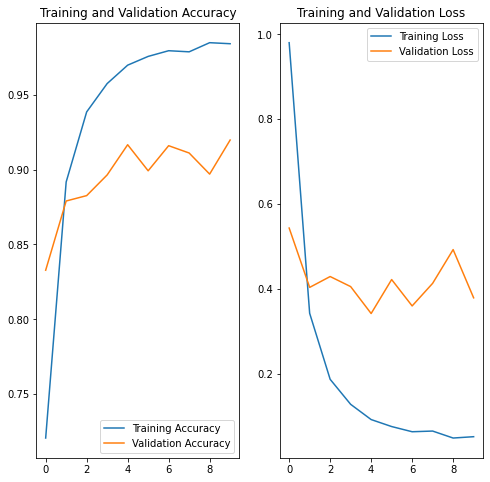

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
preformance = model.evaluate(val_ds)

340/340 [==============================] - 18s 53ms/step - loss: 0.3786 - accuracy: 0.9197


In [18]:
preformance

[0.3785606622695923, 0.9197127223014832]

actual label: Grape___healthy
predicted label: Grape___healthy


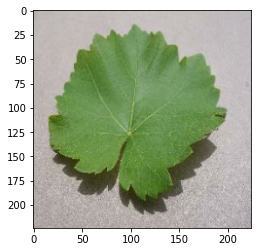

In [21]:
labels = train_ds.class_names
labels
for images_batch, labels_batch in test.take(1):
    
    image = images_batch[0].numpy().astype('uint8')
    label = labels_batch[0].numpy()
    
    plt.imshow(image)
    print("actual label:", labels[label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", labels[np.argmax(batch_prediction[0])])

In [22]:
from tensorflow import expand_dims, newaxis

def predict(model, img):
    
    img_array = img.numpy()
    img_array = expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = labels[np.argmax(predictions[0])]
    confidence = round( (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

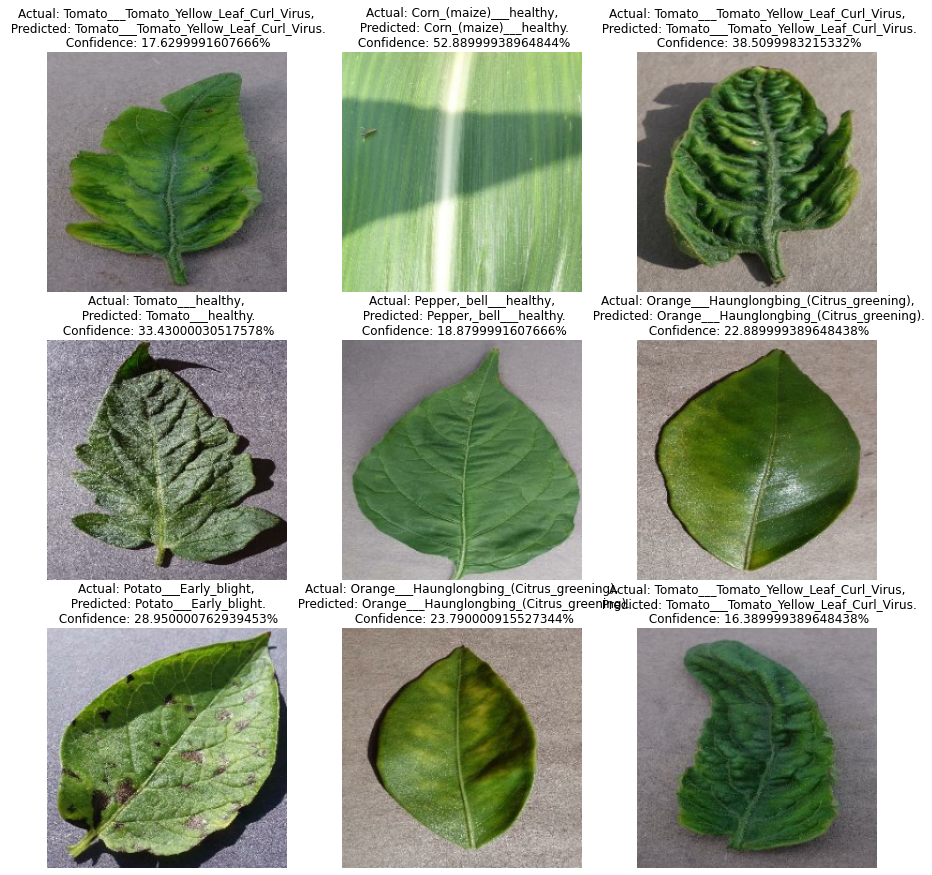

In [23]:
plt.figure(figsize=(15, 15))

for images, lbs in val_ds.take(1):
    for i in range(9):
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint32"))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = labels[lbs[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [24]:
model.save("Model.h5")